In [1]:
import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
from keras import models
import pandas as pd


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
data = pd.read_csv('Advertising.csv', index_col = 0)

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
np.random.seed(1)
X = data.drop(columns = 'sales')
y = data['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=1)

In [4]:
print(f"Number of observations in training set: {len(X_train)}")
print(f"Number of observations in test set: {len(X_test)}")

Number of observations in training set: 175
Number of observations in test set: 25


In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [6]:
X_train = pd.DataFrame(X_train_sc, index = X_train.index, columns = X_train.columns)
X_test = pd.DataFrame(X_test_sc, index = X_test.index, columns = X_test.columns)

## Problem 1

The function below takes layer_size and dropout_rate as the two arguments. This is so we can later modify them and test the model performance on different architectures. Since the first question requires us to build a two layer network with no dropout, we will set the dropout_rate argument to 0. 

In [7]:
def build_model(layer_size, dropout_rate = 0):
    np.random.seed(1)
    tf.random.set_seed(1)
    model = models.Sequential()
    model.add(layers.Dense(layer_size, activation='relu', input_shape=(X_train.shape[1],), name = 'Hidden_Layer_1'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(layer_size, activation='relu', name = 'Hidden_Layer_2'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, name="Output_Layer"))
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    return model

In [8]:
epochs = 150
validation_split = (25/175) 
model_1 = build_model(10)

In [9]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer_1 (Dense)       (None, 10)                40        
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 10)                110       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 11        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpxgmv9v6f.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpxgmv9v6f.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


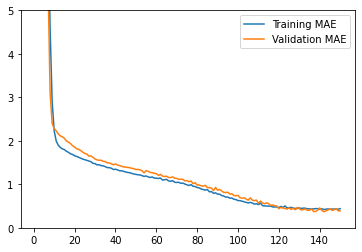

In [10]:
history_1 = model_1.fit(X_train, y_train, batch_size = 3, epochs = epochs, 
                        validation_split = validation_split, verbose=False)
plt.plot(range(1,epochs+1), history_1.history['mae'])
plt.plot(range(1,epochs+1), history_1.history['val_mae'])
plt.ylim(0,5)
plt.legend(('Training MAE','Validation MAE'))

In [11]:
history_1.history['val_mae'][149] #Validation MAE at Epoch 150

0.38990896940231323

In [12]:
history_1.history['mae'][149] #Training MAE at Epoch 150

0.44007569551467896

Looking at the plot above, the validation and training curves both seem to go down as the number of epochs increases. We can see that by around 130 epochs, both of the errors follow a horizontal line. Looking at the validation MAE and training MAE on the 150th epoch, both are similar and quite low, indicating that our simple neural network model has fitted the data pretty well.

## Problem 2

According to F. Chollet (author of Deep Learning with Python), unfortunately, there is no magical formula to determine the right number of layers or the right size for each layer (the number of hidden units). We have to evaluate an array of different architectures (on our validation set) in order to find the
correct model size for our data. The general workflow we used to find an appropriate model
size was to start with only 2 hidden units for each layer, and increase the size of the layers until
we saw diminishing returns with regard to validation loss. We tested four different architectures. As seen below, the model with 100 hidden units per layer ends up having a fluctuating validation loss, and the model with 500 hidden units seems to have an even more fluctuating validation loss. This indicates that the models with very large hidden layers are overfitting the data. Taking this into account, we selected the model with 10 hidden units since it seems to fit the data pretty fell without overfitting too much.

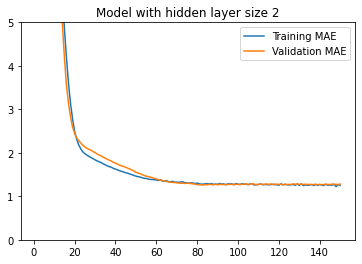

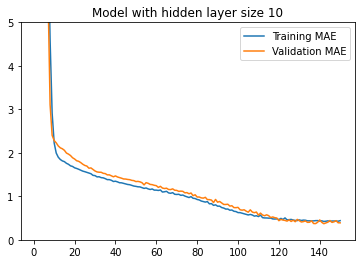

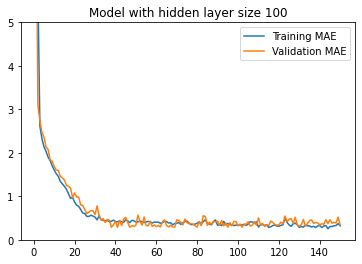

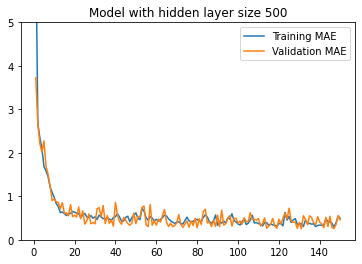

In [13]:
sizes = [2, 10, 100, 500]
for size in sizes:
    current_model = build_model(size, dropout_rate=0) #keeping dropout rate at 0
    current_history = current_model.fit(X_train, y_train, batch_size = 3, epochs = epochs, 
                    validation_split = validation_split, verbose=False)
    plt.figure()
    plt.plot(range(1,epochs+1), current_history.history['mae'])
    plt.plot(range(1,epochs+1), current_history.history['val_mae'])
    plt.ylim(0,5)
    plt.legend(('Training MAE','Validation MAE'))
    plt.title(f"Model with hidden layer size {size}")

## Problem 3

In [14]:
model_with_dropout =  build_model(layer_size = 10, dropout_rate = 0.2)
history_2 = model_with_dropout.fit(X_train, y_train, batch_size = 3, epochs = epochs, 
                    validation_split = validation_split, verbose=False)

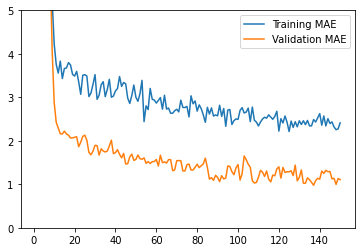

In [15]:
plt.plot(range(1,epochs+1), history_2.history['mae'])
plt.plot(range(1,epochs+1), history_2.history['val_mae'])
plt.ylim(0,5)
plt.legend(('Training MAE','Validation MAE'))


In [16]:
history_2.history['val_mae'][149] #Validation MAE on the 150th epoch

1.107270359992981

In [17]:
history_2.history['mae'][149] #Training MAE on the 150th epoch

2.412034034729004

While we might be inclined to use 0.5 as the dropout rate, which follows the recommendations from the original Dropout paper by Hinton at al, note that the size of our network is not that big to begin with. As such, we will use 0.2 as the dropout rate since it falls within the reasonable range suggested by F. Chollet, and doesn't seem to be too severe.

Looking at the plot, it seems that the training MAE is higher than than the validation MAE after about 15 epochs. While this may seem counter-intuitive at first, there is indeed an explanation behind why this is the case. According to Keras' documentation , regularization mechanisms such as dropout are turned off when evaluating the model during validation. This is reflected in the training loss but not in the validation loss. In fact, the training loss that Keras displays is the average of the losses for each batch of training data, over the current epoch. Because our model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. This can bring the epoch-wise average down. On the other hand, the validation loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss.

Furthermore, note that both training and validation MAE of this model is higher than the previous model, which could imply that regularizing the model through dropout could be counter-effective since we have such a small network to begin with.

## Problem 4

In [18]:
test_performance_model_1 =  model_1.evaluate(X_test, y_test, verbose = 0)
print(test_performance_model_1)
test_performance_model_2 =  model_with_dropout.evaluate(X_test, y_test, verbose = 0)
print(test_performance_model_2)

[0.295023649930954, 0.3550246059894562]
[2.087641716003418, 1.2895746231079102]


In [19]:
mae_1 = test_performance_model_1[1] #First Model MAE on test set
mae_2 = test_performance_model_2[1] #Second Model MAE on test set

In [20]:
mae_1

0.3550246059894562

In [21]:
mae_2

1.2895746231079102

It looks like the network with two hidden layers and no dropout layers has a lower MAE on test data as compared to the network with 2 hidden layers and 2 dropout layers. This is because when a network is small relative to the dataset, regularization through dropout is usually unnecessary. If the model capacity is already low, lowering it further by adding regularization will hurt performance, which might explain why the model with two dropout layers has a higher MAE.